<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/AndreySusarev/Profpatolog_GB_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Грузим библиотеки
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LSTM
from tensorflow.keras.layers import Activation
!pip install keras-tuner --upgrade
from tensorflow.keras import utils
from keras_tuner.tuners import Hyperband, BayesianOptimization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy import stats

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.0 MB/s eta 0:00:00


In [2]:
# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import ModelCheckpoint

## Загрузка и предобработка датасета

In [ ]:
# и таблицу
# data = pd.read_excel('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx')

In [3]:
# Подключим диск
from google.colab import drive
drive.mount('/content/drive')

# и сохраним туда исходную таблицу
# data.to_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/data_2.xlsx')

Mounted at /content/drive


In [4]:
# Загрузим таблицу для обработки
data = pd.read_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/data_2.xlsx')

In [5]:
# Вычислим возраст клиентов, результат запишим в отдельную колонку

data['Возраст'] = (data['ДатаЗавершенияМедосмотра'] - data['КлиентДатаРождения']).dt.days // 365

In [6]:
# Посмотрим...
# display(data.head())
data[['КлиентДатаРождения', 'ДатаЗавершенияМедосмотра', 'Возраст']].head()

,КлиентДатаРождения,ДатаЗавершенияМедосмотра,Возраст
0,1976-10-24,2022-01-25,45
1,1987-11-18,2022-02-02,34
2,1985-09-08,2022-02-15,36
3,1988-04-25,2022-02-16,33
4,1984-04-17,2022-02-22,37


In [7]:
# Cоздаем список с искомыми словами в названиях столбцов для последующего удаления
excluded_words = ['Представление', 'Документ', 'Контрагент', 'Врач', 'ЗаключениеМК', 'Салон', 'Дата']

# Формируем новую таблицу, удаляя столбцы из созданного списка
new_columns = [col for col in data.columns if not any(word in col for word in excluded_words)]
new_df = data[new_columns]
new_df.info()

# Также удалим столбцы "Клиент", "Unnamed: 0"
new_df=new_df.drop(columns=['Клиент', 'Unnamed: 0'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 2257 entries, Unnamed: 0 to Возраст
dtypes: bool(1), float64(856), int64(2), object(1398)
memory usage: 34.1+ MB


In [8]:
df_cut = new_df.drop(new_df.select_dtypes(include=['bool']), axis=1)                                    # удаляем колонки с типом bool
df_cut = df_cut.loc[:, df_cut.isnull().mean() < 0.8]                                                    # удаляем "почти" пустые колонки
col_list = df_cut.columns.tolist()                                                                      # список столбцов
df_cut[col_list] = df_cut[col_list].astype(str).apply(lambda x: x.str.replace(r'\W+', '', regex=True))  # удаление служебных символов из столбцов
df_cut = df_cut.applymap(lambda x: x.lower() if type(x) == str else x)                                  # заменяем все заглавные буквы на прописные

In [9]:
print(df_cut.info())
# df_cut.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 312 entries, КлиентПол to Возраст
dtypes: object(312)
memory usage: 4.7+ MB
None


In [10]:
df_cut.describe()

,КлиентПол,ТипМедосмотра,Цех,Профессия,Заключение,ДиспансернаяГруппа,ВредныеФакторы,ЛабораторныеИсследования1_Специализация,ЛабораторныеИсследования1_ОАК_Значение,ЛабораторныеИсследования1_Биохимия_Значение,...,Гинекология1_Своды2_Значение,Гинекология1_НеИзмененоСОсобенностями_Значение,Гинекология1_CтепеньЧистоты_Значение,Гинекология1_АтипичныеКлетки_Значение,Гинекология1_PSPV_Значение,Терапия1_Курение_Значение,Стоматология1_НЛ6_Значение,ПсихиатрияНаркология1_ДиагнозДополнение_Значение,Терапия1_Диагноз_Значение,Возраст
count,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982,...,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982
unique,2,2,182,588,13,8,514,4,2,2,...,2,2,3,4,3,3,9,61,18,54
top,мужской,периодический,nan,водитель,годенкработевуказанныхусловиях,i,23,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,00,nan,nan,z000общиймедицинскийосмотр_x000d_,36
freq,1451,1981,1180,64,1424,779,227,1652,1652,1655,...,1519,1519,1519,1519,1519,1105,1573,1468,856,83


In [11]:
# Создадим словарь категориальных признаков "new_df"
dicts = {}
for i in df_cut.columns.values.tolist():
    if df_cut[i].dtypes == object:
        c = 0
        dl = {}
        for j in df_cut[i].unique():
            c += 1
            dl.update({j:c})
        dicts.update({i:dl})
# dict      
    

In [12]:
# Соберем таблицу категориальных признаков на базе "df_cut" и "dicts"
df_fl = df_cut.copy()
for i in dicts.keys():
    for j in range(df_cut[i].shape[0]):
        df_fl[i][j] = float(dicts.get(i).get(df_cut[i][j]))

In [13]:
# Преобразуем в тип float
df_fl = df_fl.astype(float)
# df_fl

In [14]:
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 312 entries, КлиентПол to Возраст
dtypes: float64(312)
memory usage: 4.7 MB


In [15]:
# Нормализуем данные в таблице признаков (кроме "Заключение")
for i in df_fl.columns.values.tolist():
   if i != 'Заключение':
        df_fl[i] = df_fl[i]/df_fl[i].max()

In [16]:
# Сформируем массив данных и их значений
x=df_fl.drop(columns=['Заключение']).reset_index(drop=True)
y=df_fl['Заключение']
# x, y

In [17]:
# Пример обработанных данных
# y = np.expand_dims(y, axis=1)
print(x.shape)
print(y.shape)

(1982, 311)
(1982,)


In [18]:
y.head()

0    1.0
1    1.0
2    2.0
3    1.0
4    2.0
Name: Заключение, dtype: float64

In [26]:
# Разобъем массив на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

In [20]:
# вывод размеров обучающей и проверочной выборок
print(f'Размер обучающей выборки: {x_train.shape[0]}')
print(f'Размер проверочной выборки: {x_test.shape[0]}')

Размер обучающей выборки: 1585
Размер проверочной выборки: 397


## Предобученные алгоритмы ML

In [21]:
# Библиотеки с алгоритмами ML и функциями ошибки
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
# Поищем наилучшую конфигурацию GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

# Определяем параметры для перебора
param_grid = {'loss': ['ls', 'lad', 'huber', 'quantile'], 
    'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1.0]}

# Создаем экземпляр GradientBoostingRegressor
gb = GradientBoostingRegressor()

# Инициализация метода GridSearchCV
grid_search = GridSearchCV(gb, param_grid=param_grid, cv=5, n_jobs=-1)

# Применяем GridSearchCV к данным для обучения
grid_search.fit(x, y)

# Выводим наилучшие параметры
print('Best parameters:', grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'n_estimators': 50}


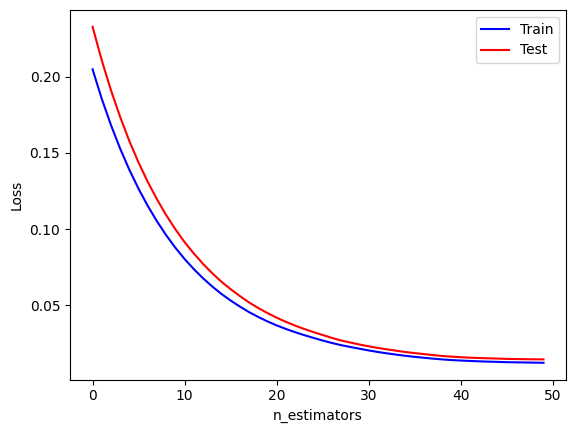

Точность на тестовых данных: 0.9628


In [27]:
# Создание и обучение экземпляра GradientBoostingRegressor с "наилучшими" параметрами
# на обучающей выборке и проверка его работы на тестовой

params = {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'n_estimators': 50}

model = GradientBoostingRegressor(**params)
model.fit(x_train, y_train)

# отображение хода обучения
train_scores = []
test_scores = []

for i, y_pred in enumerate(model.staged_predict(x_train)):
    train_scores.append(model.loss_(y_train, y_pred))
for i, y_pred in enumerate(model.staged_predict(x_test)):
    test_scores.append(model.loss_(y_test, y_pred))
    
plt.plot(train_scores, 'b', label='Train')
plt.plot(test_scores, 'r', label='Test')
plt.legend(loc='upper right')
plt.xlabel('n_estimators')
plt.ylabel('Loss')
plt.show()

# проверка на тестовой выборке
test_score = model.score(x_test, y_test)
print("Точность на тестовых данных: {:.4f}".format(test_score))